## Introduction

In this notebook, I will be building a machine learning model that identifies and predicts which Tweets (text segments shared on Twitter) are about real disasters.
Model performance will be evaluated on accuracy and its F1 score.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import re
from keras_tuner import RandomSearch, HyperParameters
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import tensorflow as tf

tf.config.set_visible_devices([], 'GPU')

import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')


train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/varshini/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Exploratory Data Analysis
The Exploratory Data Analysis includes:
1. Description of the size, dimensions and structure of the data
2. Histogram Distribution of Disaster and Non-Disaster Tweets
3. Histogram Distribution of the Top Keywords in Tweets
4. Word cloud visualizations of Disaster and Non-Disaster Tweets

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN    

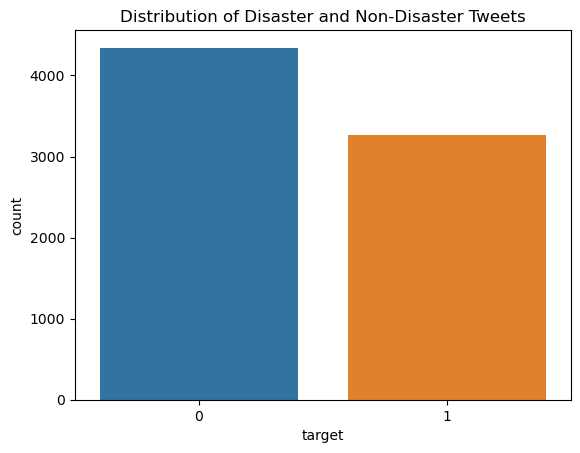

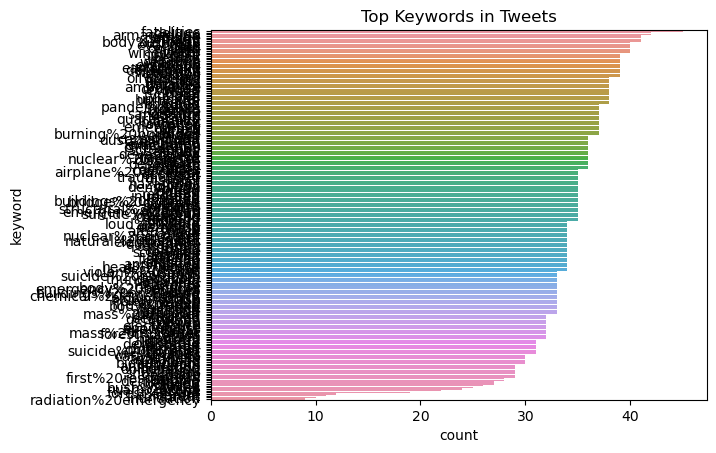

In [2]:
print(train_df.info())
print(test_df.info())
print(train_df.head())

print(train_df.isnull().sum())
sns.countplot(x='target', data=train_df)
plt.title('Distribution of Disaster and Non-Disaster Tweets')
plt.show()
sns.countplot(y='keyword', data=train_df.sort_values(by='keyword'), order=train_df['keyword'].value_counts().index)
plt.title('Top Keywords in Tweets')
plt.show()

Disaster Tweets Word Cloud:


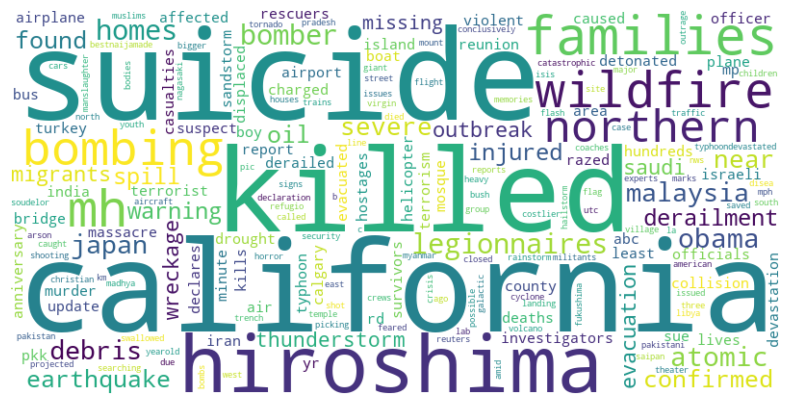

Non-Disaster Tweets Word Cloud:


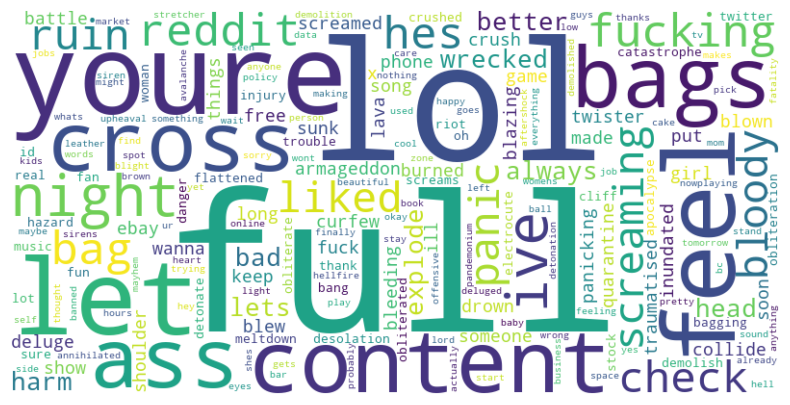

In [3]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

train_df['text'] = train_df['text'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)
train_df['keyword'].fillna('missing', inplace=True)
test_df['keyword'].fillna('missing', inplace=True)
train_df.drop('location', axis=1, inplace=True)
test_df.drop('location', axis=1, inplace=True)

disaster_tweets = train_df[train_df['target'] == 1]['text']
non_disaster_tweets = train_df[train_df['target'] == 0]['text']

def get_word_frequency(texts):
    stop_words = set(stopwords.words('english'))
    words = []
    for text in texts:
        for word in text.split():
            if word not in stop_words:
                words.append(word)
    return Counter(words)

disaster_freq = get_word_frequency(disaster_tweets)
non_disaster_freq = get_word_frequency(non_disaster_tweets)

common_words = set(disaster_freq.keys()).intersection(set(non_disaster_freq.keys()))
high_freq_words = {word for word in common_words if disaster_freq[word] > 10 and non_disaster_freq[word] > 10}

def generate_word_cloud(frequencies):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(frequencies)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

disaster_wordcloud_data = {word: freq for word, freq in disaster_freq.items() if word not in high_freq_words}
non_disaster_wordcloud_data = {word: freq for word, freq in non_disaster_freq.items() if word not in high_freq_words}

print("Disaster Tweets Word Cloud:")
generate_word_cloud(disaster_wordcloud_data)

print("Non-Disaster Tweets Word Cloud:")
generate_word_cloud(non_disaster_wordcloud_data)


## Data Cleaning
Cleaning and Data Preprocessing includes:
1. Making all the text lower case
2. Removing special characters
3. Tokenize and pad the text
4. Split the training data set into training and validation sets

In [4]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pd.concat([train_df['text'], test_df['text']]))
X = pad_sequences(tokenizer.texts_to_sequences(train_df['text']), maxlen=50)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_df['text']), maxlen=50)
y = train_df['target'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Model building
This step includes:
1. Building the model
2. Model validation
3. Hyperparameter Optimization

In [5]:
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=50))
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=256, step=32),
    return_sequences=True))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=256, step=32)))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
    loss='binary_crossentropy',
    metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5, 
    executions_per_trial=2,
    directory='my_dir',
    project_name='ktn_tweet_disaster'
)

tuner.search(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

model = tuner.hypermodel.build(best_hps)

Reloading Tuner from my_dir/ktn_tweet_disaster/tuner0.json


## Final Model and Predictions
Now that we have determined the best parameters, we:
1. Build the final model using these parameters
2. Use the F1 score to evaluate this model
3. Generate predictions on the test set

In [6]:
model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

y_pred = (model.predict(X_val) > 0.5).astype(int)
f1 = f1_score(y_val, y_pred)
print('F1 Score:', f1)

test_predictions = (model.predict(X_test) > 0.5).astype(int)

Epoch 1/10
191/191 [==============================] - 5s 24ms/step - loss: 0.5774 - accuracy: 0.6851 - val_loss: 0.4539 - val_accuracy: 0.7971
Epoch 2/10
191/191 [==============================] - 4s 22ms/step - loss: 0.3413 - accuracy: 0.8619 - val_loss: 0.4531 - val_accuracy: 0.8063
Epoch 3/10
191/191 [==============================] - 4s 23ms/step - loss: 0.2016 - accuracy: 0.9251 - val_loss: 0.5959 - val_accuracy: 0.7722
Epoch 4/10
191/191 [==============================] - 5s 24ms/step - loss: 0.1294 - accuracy: 0.9553 - val_loss: 0.6208 - val_accuracy: 0.7814
Epoch 5/10
191/191 [==============================] - 4s 24ms/step - loss: 0.0954 - accuracy: 0.9668 - val_loss: 0.8034 - val_accuracy: 0.7715
Epoch 6/10
191/191 [==============================] - 4s 23ms/step - loss: 0.0759 - accuracy: 0.9747 - val_loss: 0.7773 - val_accuracy: 0.7748
Epoch 7/10
191/191 [==============================] - 4s 23ms/step - loss: 0.0657 - accuracy: 0.9787 - val_loss: 0.8926 - val_accuracy: 0.7695

### Export predictions for submission

In [7]:
submission_df = pd.DataFrame({'id': test_df['id'], 'target': test_predictions.flatten()})
submission_df.to_csv('submissions.csv', index=False)